In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

# What is the effect of debugging?
I noticed runs dieing randomly. It looked like some cores went to sleep, which was solved by Dave:
> Yes, when I login to a node I do see many instances that are sleeping.

> Bingo! It’s easy to turn off stdout/stderr for all tasks by passing “—output none” to srun. I just launched a 128 core run using “none” for output and it seems to be working now. I see reasonable times in times.out and now see data in traj.out. Michael, I’m launching srun inside the batch script [... snip ...]

>The environment variables and additional options were documented in Cray-specific SLURM webpage. The copy of parsplice to /tmp was an attempt to move the executable off of Lustre. I think the binding-related changes here are worth keeping but the other tweaks may not be necessary. Anyway, there it is.

In addition, I noticed runs dieing... for example, below:
- debugging off has longer trajectories and a bigger decay
- debugging on stops computing trajectories... in this case, 4 hours didn't run and I had to pull in a run from a previous day to get the blue curve

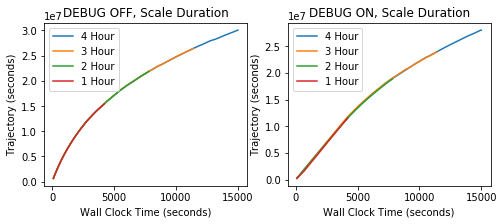

In [2]:
RAW_DF   = 0
COUNT_DF = 1
rank_names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB", "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

def plot_times(ax, label, results, lt='-'):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label)
    ax.set_ylabel("Trajectory (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
d = "../experiments/baseline-trinitite/"
ax[0].set_title("DEBUG OFF, Scale Duration")
plot_times(ax[0], "4 Hour", d+"nano/scale-length-hr4-60717-nodebug")
plot_times(ax[0], "3 Hour", d+"nano/scale-length-hr3-nodebug-60716")
plot_times(ax[0], "2 Hour", d+"nano/scale-length-hr2-nodebug-60715")
plot_times(ax[0], "1 Hour", d+"nano/scale-length-hr1-nodebug-60714")

ax[1].set_title("DEBUG ON, Scale Duration")
plot_times(ax[1], "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971/")
plot_times(ax[1], "3 Hour", d+"nano/scale-length-hr3-60682")
plot_times(ax[1], "2 Hour", d+"nano/scale-length-hr2-60681")
plot_times(ax[1], "1 Hour", d+"nano/scale-length-hr1-60678")

In [3]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
        print "...", name, 
    print "... DONE!"
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971/"))
stats.append(parse(dfs, "3 Hour", d+"nano/scale-length-hr3-60682"))
stats.append(parse(dfs, "2 Hour", d+"nano/scale-length-hr2-60681"))
stats.append(parse(dfs, "1 Hour", d+"nano/scale-length-hr1-60678"))

... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... DONE!
... 3 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... DONE!
... 2 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... DONE!
... 1 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... DONE!


# So running things multiple times works sometimes...
I can now draw a better scale duration test; conclusions are the same as viz-new.

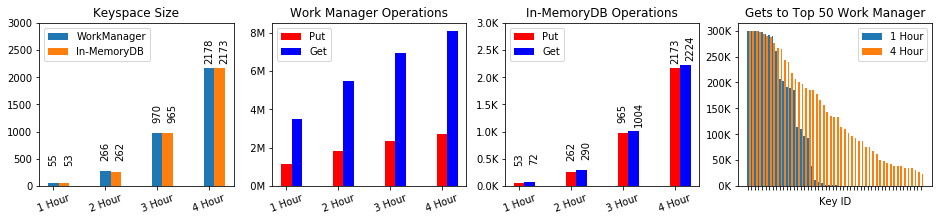

In [5]:
def plot_keyspace(key_names):
    def get_keys(op, rank):
        ret = []
        for name in key_names:
            ret.append((name, op, rank))
        return ret
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    ax[0].set_title("Keyspace Size")
    ax[0].set_ylim(0, 3000)
    
    x = np.arange(len(get_keys("DBMemoryPut", "4")))
    y = [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "4")]
    ax[0].bar(x, y, label="WorkManager", width=0.2)
    for i,j in zip(x,y):
        ax[0].annotate(str(int(j)),xy=(i-0.1,j+400), rotation=90)

    x = np.arange(len(get_keys("DBMemoryPut", "3"))) + 0.2
    y = [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "3")]
    ax[0].bar(x, y, label="In-MemoryDB", width=0.2)
    for i,j in zip(x,y):
        ax[0].annotate(str(int(j)),xy=(i,j+400), rotation=90)    
    
    ###################################################################################
    ax[1].set_title("Work Manager Operations")
    x = np.arange(len(get_keys("DBMemoryPut", "4")))
    y = [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryPut", "4")]
    ax[1].bar(x, y, label="Put", width=0.2, color='red')

    x = np.arange(len(get_keys("DBMemoryGet", "4"))) + 0.2
    y = [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryGet", "4")]
    ax[1].bar(x, y, label="Get", width=0.2, color='blue')
    ax[1].set_yticklabels(['{:3.0f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    ###################################################################################
    ax[2].set_title("In-MemoryDB Operations")
    ax[2].set_ylim(0, 3000)
    x = np.arange(len(get_keys("DBMemoryPut", "3")))
    y = [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryPut", "3")]
    ax[2].bar(x, y, label="Put", width=0.2, color='red')
    for i,j in zip(x,y):
        ax[2].annotate(str(int(j)),xy=(i-0.1,j+400), rotation=90)
    
    x = np.arange(len(get_keys("DBMemoryGet", "3"))) + 0.2
    y = [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryGet", "3")]
    ax[2].bar(x, y, label="Get", width=0.2, color='blue')
    ax[2].set_yticklabels(['{:3.1f}K'.format(axis/1000) for axis in ax[2].get_yticks()])
    for i,j in zip(x,y):
        ax[2].annotate(str(int(j)),xy=(i,j+400), rotation=90)

    for a in range(0, len(ax)):
        ax[a].set_xticklabels([0] + [k[0] for k in get_keys("DBMemoryPut", "4")], rotation=20)
        ax[a].legend(loc='upper left')

    return ax
ax = plot_keyspace(["1 Hour", "2 Hour", "3 Hour", "4 Hour"])

def plot_keyspace(ax, dfs, key, shift=0, nkeys=50):
    df = dfs[key]['DF_KEY_COUNT'].nlargest(nkeys, 'count').head(50) # not sure why we need to do head here
    if len(df) == 0:
        return -1
    x = np.arange(len(df['key']))
    ax.bar(x + shift, df['count'], width=0.5, label=key[0])
    ax.legend()

    # cleanup graphs
    ax.set_xticks(x); ax.set_xticklabels([]); ax.set_xlabel("Key ID")
    if np.max(ax.get_yticks()) > 2000:
        ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
    ax.set_title("Gets to Top " + str(nkeys) + " Work Manager")
plot_keyspace(ax[3], dfs, ("1 Hour", "DBMemoryGet", "4"))
plot_keyspace(ax[3], dfs, ("4 Hour", "DBMemoryGet", "4"), shift=0.5)
plt.savefig("../paper/figures/keyspace-size.png", dpi=400, bbox_inches='tight')

In [6]:
stats.append(parse(dfs, "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117"))

... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... DONE!


In [7]:
stats.append(parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120"))

... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... DONE!


## More fun keyspace traces

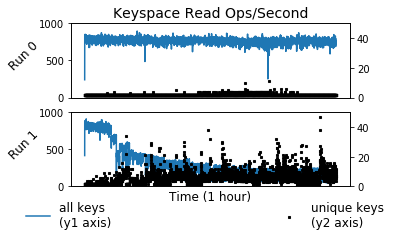

In [42]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="all keys\n(y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=5, label="unique keys\n(y2 axis)", marker='X')
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 50)
    return ax2

fig, ax = plt.subplots(2, 1, figsize=(5, 3))
#fig.subplots_adjust(hspace=-.005)
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 1M", "DBMemoryGet", "4"))
ax2 = plot_uniquekeys_per_ts(ax[1], dfs, ("Delay 100K", "DBMemoryGet", "4"))
ax[0].set_xlabel("")
for i in range(0, len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (1 hour)", fontsize=12)
ax[1].legend(bbox_to_anchor=(-0.2, -0.05), loc='upper left', frameon=False, fontsize=12)
ax2.legend(bbox_to_anchor=(0.7, -0.05), loc='upper left', frameon=False, fontsize=12)
ax[0].set_title("Keyspace Read Ops/Second", fontsize=14)
ax[0].set_ylabel("Run 0", rotation=45, fontsize=12)
ax[1].set_ylabel("Run 1", rotation=45, fontsize=12)
ax[1].yaxis.labelpad = 10
ax[0].yaxis.labelpad = 10

plt.savefig("../paper/figures/keyspace-regimes.png", dpi=400, bbox_inches='tight')

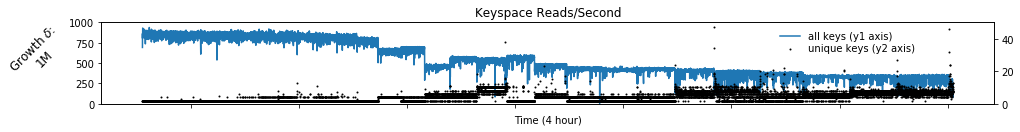

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 1.5))
ax2 = plot_uniquekeys_per_ts(ax, dfs, ("4 Hour", "DBMemoryGet", "4"))
ax.set_title("Keyspace Reads/Second")
ax.set_xticklabels([])
ax.set_xlabel("Time (4 hour)")
ax.set_ylabel(r'Growth $\delta$: ' + '\n1M', rotation=45, fontsize=12)
ax.yaxis.labelpad = 20
ax.set_ylim(0, 1000)
ax.legend(bbox_to_anchor=(0.75, 1), loc='upper left', frameon=False)
ax2.legend(bbox_to_anchor=(0.75, 0.85), loc='upper left', frameon=False)
plt.savefig("../paper/figures/keyspace-regimes-4hr.png", dpi=400, bbox_inches='tight')